In [37]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
!pip install Levenshtein
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
from Levenshtein import distance as lev

fatal: destination path 'AMPLify-Feedback' already exists and is not an empty directory.


In [38]:
generator = tf.keras.models.load_model('/content/AMPLify-Feedback/model_weights/PeptideGenerator_V2.keras')

In [39]:
generator.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, 326)]                0         []                            
                                                                                                  
 Input0 (InputLayer)         [(None, 2)]                  0         []                            
                                                                                                  
 Input1Transform (Dense)     (None, 2)                    654       ['Input1[0][0]']              
                                                                                                  
 Concat (Concatenate)        (None, 4)                    0         ['Input0[0][0]',              
                                                                     'Input1Transform[0][0]'

In [40]:
discriminator = tf.keras.models.load_model('/content/AMPLify-Feedback/model_weights/PeptideDiscriminator_V2.keras')

In [41]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 8170)              0         
                                                                 
 Dense0 (Dense)              (None, 512)               4183552   
                                                                 
 Dropout (Dropout)           (None, 512)               0         
                                                                 
 Dense1 (Dense)              (None, 256)               131328    
                                                                 
 Output (Dense)              (None, 1)                 257       
                                                                 
Total params: 4315137 (16.46 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 4315137 (16.46 MB)
_________________________________________________________________


In [42]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [43]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [44]:
oracle.summary()

Model: "MICPredictor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 SeqInput (InputLayer)       [(None, 190, 43)]            0         []                            
                                                                                                  
 Conv1D_0 (Conv1D)           (None, 186, 128)             27648     ['SeqInput[0][0]']            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 182, 128)             82048     ['Conv1D_0[0][0]']            
                                                                                                  
 Flatten_0 (Flatten)         (None, 23296)                0         ['Conv1D_1[0][0]']            
                                                                                       

In [45]:
# GAN
def compile_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input0 = layers.Input(shape=(latent_dim,))
    gan_input1 = layers.Input(shape=(326,))
    gan_output = discriminator(generator([gan_input0, gan_input1]))
    gan = tf.keras.Model([gan_input0, gan_input1], gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [46]:
def generate_sequences(generator, latent_dim, num_sequences):
    noise = np.random.normal(0, 1, (num_sequences, latent_dim))
    bacteria = []
    for i in range(num_sequences):
      bacterium = np.zeros(326)
      bacterium[np.random.randint(0, 326)]=1
      bacteria.append([bacterium])
    bacteria = np.concatenate(bacteria, axis=0)
    generated_sequences = generator.predict([noise, bacteria])
    return generated_sequences, bacteria

In [47]:
def fit_gan(generator, discriminator, gan, seq_train, state_train, labels, epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        for i in range(0, seq_train.shape[0], batch_size):
            sequences = seq_train[i:i + batch_size]
            state_train_batch = state_train[i:i + batch_size]
            current_batch_size = sequences.shape[0]

            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(sequences, labels, return_dict=True)
            discriminator.trainable = False

            # Train generator
            noise = np.random.normal(0, 1, (current_batch_size, latent_dim))
            g_loss = gan.train_on_batch([noise, state_train_batch], labels)

            # Print the progress
            print(f"Epoch {epoch+1}/{epochs}, Batch {i//batch_size+1}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")
            return d_loss, g_loss

In [48]:
def label_from_MIC(prediction, threshold):
  loop_prediction = np.zeros((prediction.shape[0], 1))
  for i in range (prediction.shape[0]):
    if prediction[i] < threshold:
      loop_prediction[i] = 1
  return loop_prediction

In [49]:
def variability_metrics(sequences):
  pairs = []
  total_lev = 0
  index = 0
  aa_vocal = np.load("AMPLify-Feedback/model_weights/SeqTV_vocal.npy")
  pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')
  decoded_sequences = []
  for s in sequences:
    chars_array = pep_decoder(tf.math.argmax([s], axis=2)).numpy().astype('str')
    decoded_sequences += ["".join(chars) for chars in chars_array]
  for s1 in range(len(decoded_sequences)):
                for s2 in range(s1+1,len(decoded_sequences)):
                        total_lev += lev(decoded_sequences[s1],decoded_sequences[s2])
                        index += 1
  return total_lev/index

In [50]:
def RL_loop(generator, discriminator, gan, oracle, num_sequences, epochs):
  d_loss, d_accuracy, g_loss, average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein  = [], [], [], [], [], [], [], []
  MIC_threshold = math.log(100,2)
  for i in range (n_iter_max) :
    sequences, bacteria = generate_sequences(generator, latent_dim, num_sequences)
    prediction = oracle.predict([sequences, bacteria])
    average_mic_train += [np.mean(prediction)]
    min_mic_train += [np.min(prediction)]
    max_mic_train += [np.max(prediction)]
    median_mic_train += [np.median(prediction)]
    levenstein += [variability_metrics(sequences)]
    loop_prediction = label_from_MIC(prediction, MIC_threshold)
    d_results, g_results = fit_gan(generator, discriminator, gan, sequences, bacteria, loop_prediction, epochs=epochs, batch_size=num_sequences, latent_dim=latent_dim)
    d_loss += [d_results['loss']]
    d_accuracy += [d_results['accuracy']]
    g_loss += [g_results]
  return d_loss, d_accuracy, g_loss, average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein

In [51]:
def display(parameters):
  for p in list(parameters.keys()):
    plt.plot(range(len(parameters[p])), parameters[p], linestyle='-', label = p)
  plt.legend(loc = "upper right")
  plt.ylabel("Value")
  plt.xlabel("Iteration index")
  plt.title("Performances with the feedback loop")
  plt.show()

32/32 [==============================] - 4s 126ms/step
Epoch 1/10, Batch 1, Discriminator Loss: {'loss': 4.1457295417785645, 'accuracy': 0.04600000008940697}, Generator Loss: 4.166723728179932
32/32 [==============================] - 3s 105ms/step
Epoch 1/10, Batch 1, Discriminator Loss: {'loss': 4.003513813018799, 'accuracy': 0.05700000002980232}, Generator Loss: 4.004539966583252
32/32 [==============================] - 2s 55ms/step
Epoch 1/10, Batch 1, Discriminator Loss: {'loss': 3.7954742908477783, 'accuracy': 0.07500000298023224}, Generator Loss: 3.7674405574798584
32/32 [==============================] - 2s 54ms/step
Epoch 1/10, Batch 1, Discriminator Loss: {'loss': 3.5308589935302734, 'accuracy': 0.10000000149011612}, Generator Loss: 3.6091175079345703
32/32 [==============================] - 3s 89ms/step
Epoch 1/10, Batch 1, Discriminator Loss: {'loss': 3.413855791091919, 'accuracy': 0.10599999874830246}, Generator Loss: 3.4849889278411865
32/32 [==============================

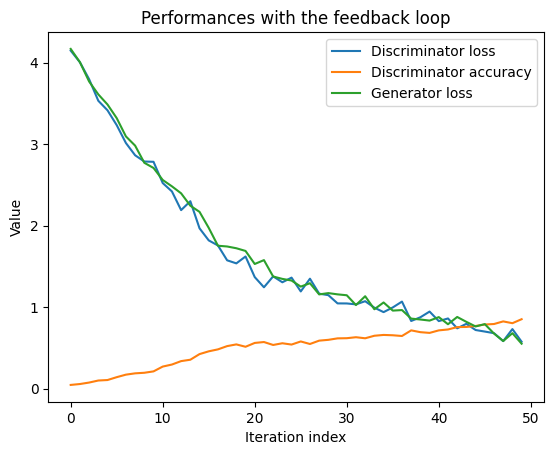

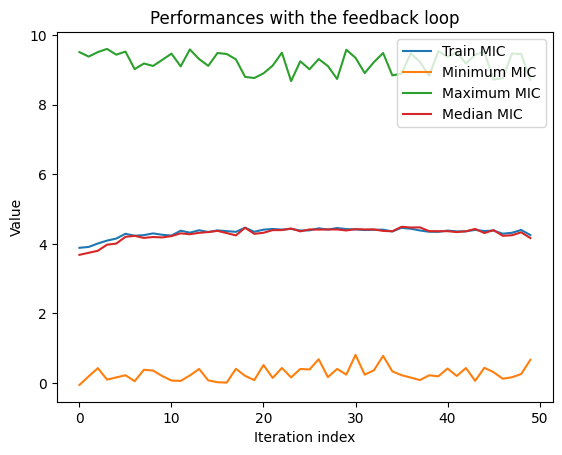

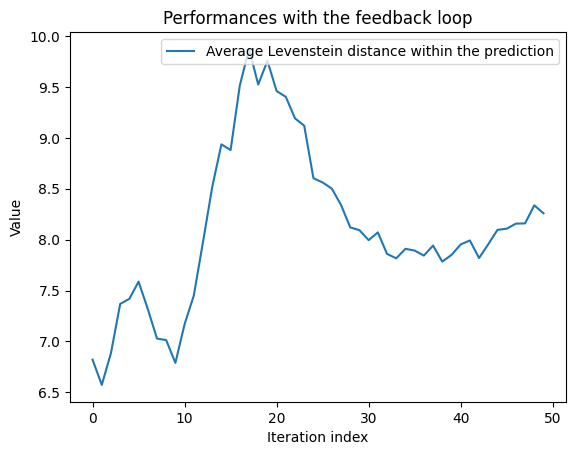

In [52]:
latent_dim = 2
num_sequences = 1000
n_iter_max = 50
epochs = 10

gan = compile_gan(generator, discriminator) #build the model
d_loss, d_accuracy, g_loss, average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein = RL_loop(generator, discriminator, gan, oracle, num_sequences, epochs)
display({"Discriminator loss" : d_loss, "Discriminator accuracy" : d_accuracy, "Generator loss" : g_loss})
display({"Train MIC" : average_mic_train, "Minimum MIC" : min_mic_train, "Maximum MIC" : max_mic_train, "Median MIC" : median_mic_train})
display({"Average Levenstein distance within the prediction" : levenstein})

In [53]:
generator.save("/content/AMPLify-Feedback-main/model_weights/LoopGenerator_V2.keras")
discriminator.save("/content/AMPLify-Feedback-main/model_weights/LoopDiscriminator_V2.keras")

FileNotFoundError: ignored